In [183]:
import numpy as np
import tensorflow as tf


# Get the MNIST Data
mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(len(x_train), len(y_test))

labels = {0 : "T-shirt/top",
          1	: "Trouser",
          2	: "Pullover",
          3	: "Dress",
          4	: "Coat",
          5	: "Sandal",
          6	: "Shirt",
          7	: "Sneaker",
          8	: "Bag",
          9	: "Ankle boot"}


60000 10000


In [184]:
n_qubits = 6                  # Number of qubits
num_layers = 1                # Number of layers

is_data_reduced = True        # Data is reduced to n classes
reduced_classes = [1,2,3,7]   # Selected (and sorted) classes

reduced_labels = [labels[v] for v in reduced_classes]

# Number of reduced classes
reduced_num_classes = len(reduced_classes)

reduce_scale = 2

if reduce_scale:
  x_train = x_train[:int(len(x_train)/reduce_scale)]
  y_train = y_train[:int(len(y_train)/reduce_scale)]

  x_test = x_test[:int(len(x_test)/reduce_scale)]
  y_test = y_test[:int(len(y_test)/reduce_scale)]

In [185]:
# All indexes
train_index_f = (y_train == -1)
tests_index_f = (y_test  == -1)

if is_data_reduced:
  # Filter indexes
  for n_class in reduced_classes:
    train_index_f   |= (y_train == n_class) 
    tests_index_f   |= (y_test == n_class)

  num_classes_q = reduced_num_classes

# New databases
X_ends_pre = x_train[train_index_f]
Y_ends_pre = y_train[train_index_f]

X_tests_pre = x_test[tests_index_f]
Y_tests_pre = y_test[tests_index_f]


if is_data_reduced:
  # Change categories to their new range.
  # E.g. {0,...,9} -> {0,...,4}
  for i, k in enumerate(reduced_classes):
    Y_ends_pre[Y_ends_pre == k] = i
    Y_tests_pre[Y_tests_pre == k] = i

In [186]:
# All indexes
train_index_f = (y_train == -1)
tests_index_f = (y_test  == -1)

if is_data_reduced:
  # Filter indexes
  for n_class in reduced_classes:
    train_index_f   |= (y_train == n_class) 
    tests_index_f   |= (y_test == n_class)

  num_classes_q = reduced_num_classes

# New databases
X_ends_pre = x_train[train_index_f]
Y_ends_pre = y_train[train_index_f]

X_tests_pre = x_test[tests_index_f]
Y_tests_pre = y_test[tests_index_f]


if is_data_reduced:
  # Change categories to their new range.
  # E.g. {0,...,9} -> {0,...,4}
  for i, k in enumerate(reduced_classes):
    Y_ends_pre[Y_ends_pre == k] = i
    Y_tests_pre[Y_tests_pre == k] = i

In [187]:
latent_dim = 2 ** n_qubits    # Selected latent dimensions

class Autoencoder(tf.keras.models.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(name = "faltten_1"),
      tf.keras.layers.Dense(196, activation='relu', name = "dense_1"),
      tf.keras.layers.Dense(64, activation='relu', name = "dense_2"),
      tf.keras.layers.Dense(latent_dim, activation='relu', name = "dense_3"),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu', name = "dense_4"),
      tf.keras.layers.Dense(196, activation='relu', name = "dense_5"),
      tf.keras.layers.Dense(784, activation='sigmoid', name = "dense_6"),
      tf.keras.layers.Reshape((28, 28), name = "reshape_1")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Prepare and compile the model
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='mae', metrics=["accuracy"])

# Train the model with the filtered data
autoencoder.fit(X_ends_pre, X_ends_pre, epochs=100, shuffle=True, validation_data=(X_tests_pre, X_tests_pre))


Epoch 1/100
377/377 [==============================] - 2s 3ms/step - loss: 0.1151 - accuracy: 0.1033 - val_loss: 0.0785 - val_accuracy: 0.1261
Epoch 2/100
377/377 [==============================] - 1s 3ms/step - loss: 0.0717 - accuracy: 0.1426 - val_loss: 0.0675 - val_accuracy: 0.1516
Epoch 3/100
377/377 [==============================] - 1s 3ms/step - loss: 0.0640 - accuracy: 0.1603 - val_loss: 0.0619 - val_accuracy: 0.1629
Epoch 4/100
377/377 [==============================] - 1s 3ms/step - loss: 0.0599 - accuracy: 0.1719 - val_loss: 0.0584 - val_accuracy: 0.1809
Epoch 5/100
377/377 [==============================] - 1s 3ms/step - loss: 0.0565 - accuracy: 0.1864 - val_loss: 0.0586 - val_accuracy: 0.1967
Epoch 6/100
377/377 [==============================] - 1s 3ms/step - loss: 0.0543 - accuracy: 0.1960 - val_loss: 0.0542 - val_accuracy: 0.2055
Epoch 7/100
377/377 [==============================] - 1s 3ms/step - loss: 0.0525 - accuracy: 0.2032 - val_loss: 0.0532 - val_accuracy: 0.2077

KeyboardInterrupt: 

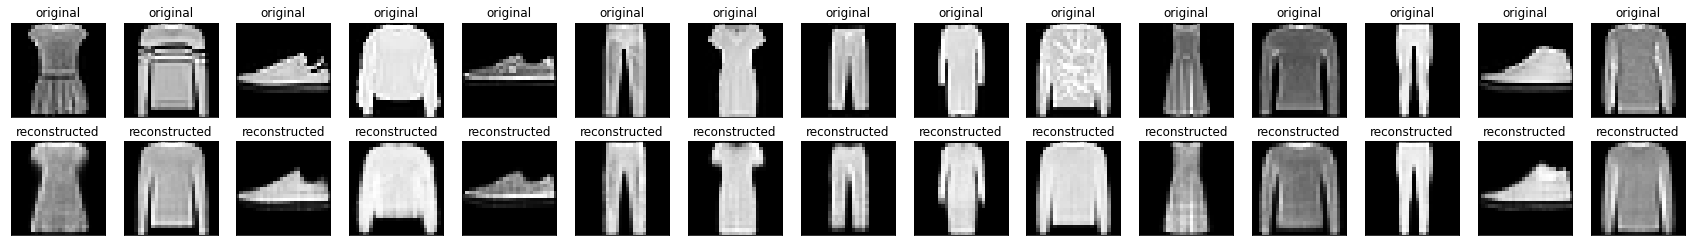

In [188]:
import matplotlib.pyplot as plt

encoded_imgs = autoencoder.encoder(X_ends_pre).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 15
plt.figure(figsize=(30, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_ends_pre[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [189]:
# Encode data with our new autoencoder
QX_train = autoencoder.encoder(X_ends_pre).numpy()
QX_test = autoencoder.encoder(X_tests_pre).numpy()

# Change Y values to categorical
QY_train = tf.keras.utils.to_categorical(Y_ends_pre, num_classes_q)
QY_test = tf.keras.utils.to_categorical(Y_tests_pre, num_classes_q)

In [190]:
import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers

In [191]:
dev = qml.device("default.qubit", wires = n_qubits)

@qml.qnode(dev, diff_method='adjoint')
def circuit(weights, inputs=None):
  ''' Quantum QVC Circuit'''

  # Splits need to be done through the tensorflow interface
  weights_each_layer = tf.split(weights, num_or_size_splits=num_layers, axis=0)
  
  # Input normalization
  inputs_1 = inputs / p_np.sqrt(max(p_np.sum(inputs ** 2, axis=-1), 0.001))

  for i, W in enumerate(weights):
    # Data re-uploading technique
    if i % 2 == 0:
      MottonenStatePreparation(inputs_1, wires = range(n_qubits))
    
    # Neural network layer
    StronglyEntanglingLayers(weights_each_layer[i], wires=range(n_qubits))
  
  # Measurement return
  return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] 

In [192]:
weight_shapes = {"weights": (num_layers,n_qubits,3)}

# Model  
input_m = tf.keras.layers.Input(shape=(2 ** n_qubits,), name = "input_0")
keras_1 = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=n_qubits, name = "keras_1")(input_m)
output = tf.keras.layers.Dense(num_classes_q, activation='softmax', name = "dense_1")(keras_1)

# Model creation
model = tf.keras.Model(inputs=input_m, outputs=output, name="mnist_quantum_model")

# Model compilation
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01) ,
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [193]:
model.fit(QX_train, QY_train, epochs=1, batch_size=8, shuffle=True)

1506/1506 [==============================] - 1854s 1s/step - loss: 0.5371 - categorical_accuracy: 0.8893


In [199]:
results = model.evaluate(QX_test, QY_test)

 2/63 [..............................] - ETA: 3:07 - loss: 0.2778 - categorical_accuracy: 0.9219

KeyboardInterrupt: 

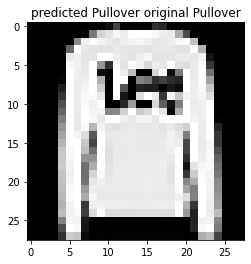

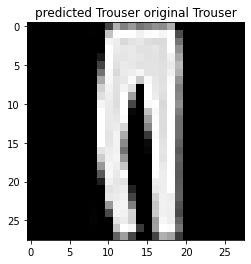

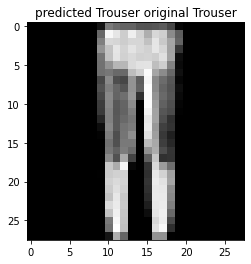

In [195]:

for i in range(0, 3):
    predicted= np.argmax(model.predict(QX_test[i:i+1]))
    plt.imshow(X_tests_pre[i])
    plt.title(f"predicted {reduced_labels[predicted]} original {reduced_labels[Y_tests_pre[i]]}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


In [196]:
predicted = model.predict(QX_test)

In [197]:
from collections import Counter
predicted_argmax = np.argmax(predicted, axis=1)
incorrect = predicted_argmax != Y_tests_pre
print(Counter(Y_tests_pre[incorrect]))

Counter({0: 49, 1: 47, 2: 32, 3: 12})


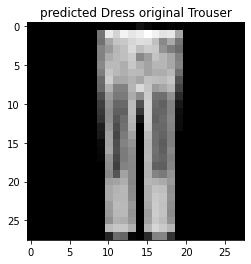

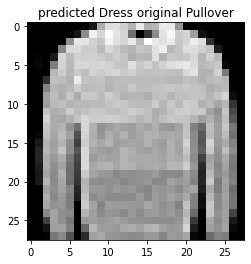

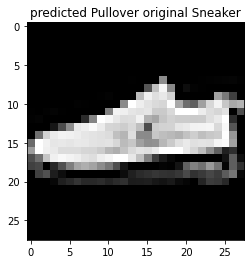

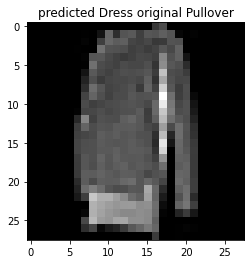

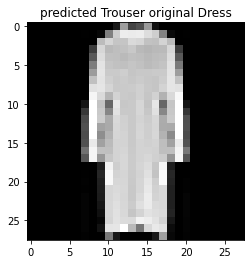

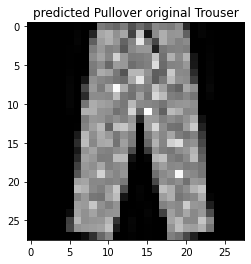

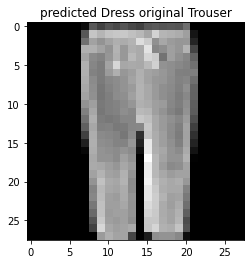

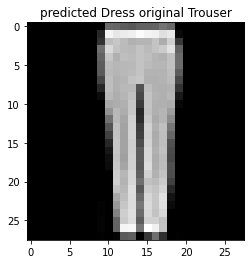

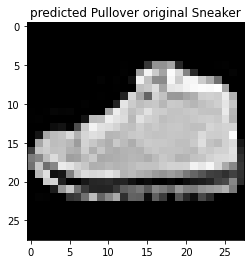

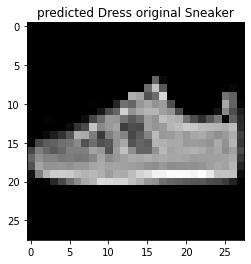

In [198]:
count = 10
x_t = X_tests_pre[incorrect][:count]
y_t = Y_tests_pre[incorrect][:count]
p_t = predicted_argmax[incorrect][:count]

for x,y,p in zip(x_t, y_t, p_t):
    plt.imshow(x)
    plt.title(f"predicted {reduced_labels[p]} original {reduced_labels[y]}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
